# SeaSoar Processing

1. Load data
2. Identify upcasts and downcasts
3. Flag spurious pressure/data points by moving median filter
4. Bin sensor data to regular pressures
5. Flag outliers in signals

In [1]:
source('source.r')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


Loading required package: ncdf4
Loading required package: R.matlab
R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: ‘R.matlab’

The following objects are masked from ‘package:base’:

    getOption, isOpen

Loading required package: openxlsx
Loading required package: RColorBrewer
Loading required package: compiler
Loading required package: lattice
Loading required package: geosphere
Loading required package: readxl
Loading required package: data.table
Loading required package: rworldmap
Loading required package: sp
Error: package or namespace load failed for ‘rworldmap’ in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 there is no package called ‘fields’
Loading required package: rworldxtra


In [2]:
input.dir = '../../Models/SeaSoar/SeaSoar1/'

files = list.files(input.dir)
files = files[grepl('.mat', files)]
length(files)

[1] 50

In [3]:
get.data = function(input.dir, file) {
    data = readMat('../../Models/SeaSoar/SeaSoar1/FLT_DAT001.mat', fixNames = TRUE)
    names = unlist(dimnames(data$data)[1])

    ## Partition up datea
    eng = as.data.frame(data$data[2:12])
    sensor = as.data.frame(data$data[13:36])
    colnames(sensor) = names[13:36]
    colnames(eng) = names[2:12]
    
    sensor$time = seq(from = eng$time[1], by = 1/24, length.out = nrow(sensor))
    
    return(list(eng = eng, sensor = sensor))
}

#### Flag Outliers in pressure
flag.p.outliers = function(data, dp = 0.5, verbose = FALSE, window = 25) {
    l = which(abs(data$sensor$p - runmed(data$sensor$p, window)) > dp)
    
    data$p.FLAG = 1 # keep
    data$p.FLAG[l] = 3 # reject
    
    if (verbose) {
        n = length(l)
        perc = floor(length(l) / nrow(data$sensor)*1000)/10
        
        print(paste0('Flagging identified ', n, ' (', perc, ') outliers.'))
    }
    data
}

In [157]:
data = get.data(input.dir, files[10])
data = flag.p.outliers(data)
str(data)

List of 2
 $ eng   :'data.frame':	6494 obs. of  11 variables:
  ..$ lat        : num [1:6494] 34.2 34.2 34.2 34.2 34.2 ...
  ..$ lon        : num [1:6494] -121 -121 -121 -121 -121 ...
  ..$ time       : num [1:6494] 1.5e+09 1.5e+09 1.5e+09 1.5e+09 1.5e+09 ...
  ..$ cog        : num [1:6494] 314 305 304 310 318 ...
  ..$ sog        : num [1:6494] 1.4 1.6 1.6 1.4 1.4 1.5 1.5 1.3 1 0.8 ...
  ..$ heading    : num [1:6494] 325 325 325 326 326 ...
  ..$ sow        : num [1:6494] -99 -99 -99 -99 -99 -99 -99 -99 -99 -99 ...
  ..$ bottomdepth: num [1:6494] 729 729 729 732 732 ...
  ..$ moogdrive  : num [1:6494] 42 42 42 42 42 42 42 42 42 42 ...
  ..$ moogmonitor: num [1:6494] -108 -108 -108 -108 -108 ...
  ..$ tension    : num [1:6494] -1 2 -1 7 8 0 9 3 8 3 ...
 $ sensor:'data.frame':	155856 obs. of  25 variables:
  ..$ t1         : num [1:155856] 12.8 12.8 12.7 12.7 12.7 ...
  ..$ t2         : num [1:155856] 12.7 12.7 12.7 12.7 12.7 ...
  ..$ p          : num [1:155856] 10.8 10.8 10.8 10.9 10.

In [4]:
bin.p = function(data, dp = 1, secs = 10) {
    
    i = 1
    while (i < nrow(data$sensor)) {
        l = which(abs(data$sensor$p - data$sensor$p[i]) + abs(data$sensor$time - data$sensor$time[i]) / secs < dp / 2)
        temp = apply(data$sensor[l,], 2, function(x) {mean(x, na.rm = TRUE)})
        
        if (length(l) > 1) {
            data$sensor[i,] = temp
            l = l[l != i]
            
            data$sensor = data$sensor[-l,]
        }
        i = i + 1
    }
    
    data
}

In [ ]:
bin.data = bin.p(data)

print(paste0('Number of Sensor Records before binning: ', nrow(data$sensor)))
print(paste0('Number of Sensor Records after binning: ', nrow(bin.data$sensor)))
print(paste0('(', floor(nrow(bin.data$sensor)*1000) / 10, '%)'))

In [ ]:
check.bin = function(data), l = c(0000:135000)) {
    plot(data$sensor$time[l], data$sensor$p[l], type='l', ylab='Pressure', xlab='Time', ylim=c(100,0), yaxs='i')
    points(bin.data$sensor$time, bin.data$sensor$p, pch=4, cex=1.5, col='blue')
}

In [5]:
process.files = function(input.dir, files, verbose = FALSE, bin = TRUE) {
    
    ## First data file
    if (verbose) {print(paste('Starting file:', files[1]))}
    data = get.data(input.dir, files[1])
    data = flag.p.outliers(data)
    n.before = nrow(data$sensor)
    
    if (verbose) {print('Binning the data.')}
    data = bin.p(data)
    if (verbose) {
        print(paste0('Number of Sensor Records before binning: ', n.before))
        print(paste0('Number of Sensor Records after binning: ', nrow(data$sensor)))
        print(paste0('(', floor(nrow(data$sensor) / n.before * 1000) / 10, '%)'))
    }
    print('-----')
    print('')
    
    for (f in 2:length(files)) {
        if (verbose) {print(paste0('Starting file: ', files[f], ' (', f, ' of ', length(files), ')'))}
        temp = get.data(input.dir, f)
        temp = flag.p.outliers(temp)
        n.before = nrow(temp$sensor)
        
        if (verbose) {print('Binning the data.')}
        temp = bin.p(temp)
        
        if (verbose) {print('Checkpoint Saved.')}
        if (verbose) {print('')}
        
        save(temp, file = paste0('RStates/Seasoar-binned-', files[f], '.rdata'))
        if (verbose) {
            print(paste0('Number of Sensor Records before binning: ', n.before))
            print(paste0('Number of Sensor Records after binning: ', nrow(temp$sensor)))
            print(paste0('(', floor(nrow(temp$sensor)/n.before * 1000) / 10, '%)'))
        }
        data$sensor = rbind(data$sensor, temp$sensor)
        data$eng = rbind(data$eng, temp$eng)
        print('-----')
        print('')
    }
    data
}

process.files.rstate = function(input.dir, files, verbose = FALSE, bin = TRUE) {
    
    ## First data file
    if (verbose) {print(paste('Starting file:', files[1]))}
    data = get.data(input.dir, files[1])
    data = flag.p.outliers(data)
    n.before = nrow(data$sensor)
    
    if (verbose) {print('Binning the data.')}
    data = bin.p(data)
    print('-----')
    print('')
    
    for (f in 2:length(files)) {
        if (verbose) {print(paste0('Starting file: ', files[f], ' (', f, ' of ', length(files), ')'))}
        load(file = paste0('RStates/Seasoar-binned-', files[f], '.rdata'))
        
        data$sensor = rbind(data$sensor, temp$sensor)
        data$eng = rbind(data$eng, temp$eng)
        print('-----')
        print('')
    }
    data
}

In [13]:
data = process.files(input.dir, files, verbose = TRUE)

[1] "Starting file: FLT_DAT001.mat"
[1] "Binning the data."
[1] "Number of Sensor Records before binning: 155856"
[1] "Number of Sensor Records after binning: 7631"
[1] "(4.8%)"
[1] "-----"
[1] ""
[1] "Starting file: FLT_DAT002.mat (2 of 50)"
[1] "Binning the data."
[1] "Checkpoint Saved."
[1] ""
[1] "Number of Sensor Records before binning: 155856"
[1] "Number of Sensor Records after binning: 7631"
[1] "(4.8%)"
[1] "-----"
[1] ""
[1] "Starting file: FLT_DAT003.mat (3 of 50)"
[1] "Binning the data."
[1] "Checkpoint Saved."
[1] ""
[1] "Number of Sensor Records before binning: 155856"
[1] "Number of Sensor Records after binning: 7631"
[1] "(4.8%)"
[1] "-----"
[1] ""
[1] "Starting file: FLT_DAT004.mat (4 of 50)"
[1] "Binning the data."
[1] "Checkpoint Saved."
[1] ""
[1] "Number of Sensor Records before binning: 155856"
[1] "Number of Sensor Records after binning: 7631"
[1] "(4.8%)"
[1] "-----"
[1] ""
[1] "Starting file: FLT_DAT005.mat (5 of 50)"
[1] "Binning the data."
[1] "Checkpoint Sav

limit_output extension: Maximum message size of 1000 exceeded with 11900 characters

In [6]:
data = process.files.rstate(input.dir, files)

[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""
[1] "-----"
[1] ""


In [1]:
str(data$sensor)

ERROR: Error in data$sensor: object of type 'closure' is not subsettable


In [ ]:
find.stops = function(data, p.min = 0, p.max = 250) {
    p = ma(data$p, 24)
    l.min = which(p < p.min)
    l.max = which(p > p.max)
    
    counter = 1
    
    if (1 %in% l.min) {
        state = -1  # Surface
    } else if (1 %in% l.max) {
        state = 1  # Depth
    } else {
        state = 0  # Profile
    }
    
    for (i in 2:nrow(data)) {
        if (i %in% l.min) {
            new.state = -1  # Surface
        } else if (i %in% l.max) {
            new.state = 1  # Depth
        } else {
            new.state = 0  # Profile
        }
        
        if (state != new.state) {
            
        }
    }
}

In [158]:
add.direction = function(data, p.min = 10, p.max = 250) {
    data$direction = NA
    
    for (i in 1:nrow(data$sensor)) {
        previous.surface = which(data$sensor$p <= p.min)
        previous.depth = which(data$sensor$p >= p.max)
        
        ## Identify if it is not at the top or bottom of profile
        if (data$sensor$p[i] > p.min & data$sensor$p[i] < p.max) {
            l.surf = previous.surface[previous.surface < i]
            l.deep = previous.depth[previous.depth < i]
            
            if (max(l.surf, 0) < max(l.deep, 0)) { # it was at depth more recently, must be going up
                data$sensor$direction[i] = 1
            } else {
                data$sensor$direction[i] = -1  ## This setup assumes it is going down by default.
            }
        }
    }
    
    data$sensor$direction[is.na(data$sensor$direction)] = 0
    data
}

Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”

ERROR: Error in plot.window(...): need finite 'xlim' values


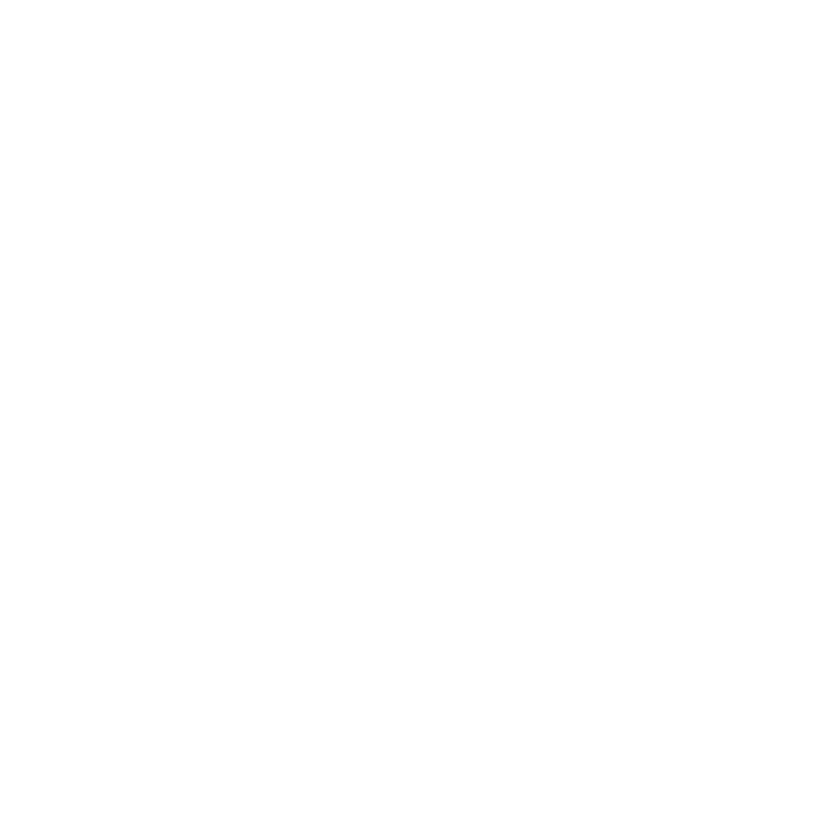

In [14]:
plot(data$sensor$time, data$sensor$p, cex=0.1, pch=20, col=get.qual.pal(3)[data$sensor$direction+2],
     ylim=c(300,0), yaxs='i', ylab='Depth', xlab='')

#points(data$sensor$time[data$sensor$p.FLAG == 3], data$sensor$p[data$sensor$p.FLAG == 3], pch=4, col='red', cex=0.5)

In [15]:
str(data)

List of 150
 $ :'data.frame':	6494 obs. of  11 variables:
  ..$ lat        : num [1:6494] 34.2 34.2 34.2 34.2 34.2 ...
  ..$ lon        : num [1:6494] -121 -121 -121 -121 -121 ...
  ..$ time       : num [1:6494] 1.5e+09 1.5e+09 1.5e+09 1.5e+09 1.5e+09 ...
  ..$ cog        : num [1:6494] 314 305 304 310 318 ...
  ..$ sog        : num [1:6494] 1.4 1.6 1.6 1.4 1.4 1.5 1.5 1.3 1 0.8 ...
  ..$ heading    : num [1:6494] 325 325 325 326 326 ...
  ..$ sow        : num [1:6494] -99 -99 -99 -99 -99 -99 -99 -99 -99 -99 ...
  ..$ bottomdepth: num [1:6494] 729 729 729 732 732 ...
  ..$ moogdrive  : num [1:6494] 42 42 42 42 42 42 42 42 42 42 ...
  ..$ moogmonitor: num [1:6494] -108 -108 -108 -108 -108 ...
  ..$ tension    : num [1:6494] -1 2 -1 7 8 0 9 3 8 3 ...
 $ :'data.frame':	6494 obs. of  11 variables:
  ..$ lat        : num [1:6494] 34.2 34.2 34.2 34.2 34.2 ...
  ..$ lon        : num [1:6494] -121 -121 -121 -121 -121 ...
  ..$ time       : num [1:6494] 1.5e+09 1.5e+09 1.5e+09 1.5e+09 1.5e+09 .

limit_output extension: Maximum message size of 1000 exceeded with 115409 characters